In [1]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

## Define Environment

In [2]:
class RandomWalkEnv:
    """Define RandomWalk environment."""
    
    def __init__(self, step=1, lr=2e-5, gamma=1, 
                 start=500, shift=100, num_states=1000, debug=True):
    
        self.step = step
        self.lr = lr
        self.gamma = gamma
        self.start = start
        self.state = self.start
        self.shift = shift
        self.num_states = num_states
        
        self.actions = ['left', 'right']
        self.end = False
        self.debug = debug
        
        self.TRUE_VALUES = np.arange(-self.num_states-1, self.num_states+3, 2) / np.float(self.num_states)
        
    def choose_action(self):
        action = np.random.choice(self.actions)
        return action
    
    def take_action(self, action):
        
        # choose steps from 1 to 100
        steps = np.random.choice(range(1, self.shift+1))
        if action == 'left':
            state = self.state - steps
        else:
            state = self.state + steps
            
        # judge if end of the game
        if state <= 0 or state >= self.num_states+1:
            self.end = True
            if state <= 0: state = 0
            else: state = self.num_states+1
                
        self.state = state
        return state
    
    def give_reward(self):
        if self.state == 0:
            return -1
        elif self.state == self.num_states+1:
            return 1
        
        return 0
    
    def reset(self):
        self.state = self.start
        self.end = False
        
    def play(self, value_function, num_episodes=1e5):
        
        max_avg_score = -np.inf
        for i_episode in range(num_episodes):
            
            self.reset()
            time_step = 0
            T = np.inf
            action = self.choose_action()
            
            actions = [action]
            states = [self.state]
            rewards = [0]
            
            while True:
                
                if time_step < T:
                    next_state = self.take_action(action)
                    reward = self.give_reward()
                    
                    states.append(next_state)
                    rewards.append(reward)
                    
                    state = next_state
                            
                    if self.end:
                        if self.debug:
                            if (i_episode+1) % 1 == 0:
                                print(f'\rEpisode: {i_episode+1}/ {num_episodes} | Max Average Score: {max_avg_score:.2f}', end='')
                                sys.stdout.flush()
                                
                        T = time_step+1
                    else:
                        action = self.choose_action()
                        actions.append(action)
                
                # the time whose estimate is being updated
                time_updated = time_step - self.step + 1
                
                if time_updated >= 0:
                    G = 0
                    for i in range(time_updated+1, min(time_updated + self.step + 1, T+1)):
                        G += np.power(self.gamma, i-time_updated-1) * rewards[i]
                        
                    if time_updated + self.step < T:
                        state = states[time_updated + self.step]
                        G += np.power(self.gamma, self.step) * value_function.value(state)
                        
                    # update value function
                    state = states[time_updated]
                    delta = self.lr * (G - value_function.value(state))
                    value_function.update(delta, state)
                
                if time_updated == T-1: break
                time_step += 1
                
            # record min average state
            avg_score = np.mean(rewards)
            
            if avg_score > max_avg_score:
                max_avg_score = avg_score

In [3]:
def plot_figure(function, func_type='Aggregate Value Function'):
    
    x_value = range(0, 1002)
    approximate_values = []
    for i in x_value:
        approximate_values.append(function.value(i))
        
    plt.figure(figsize=(8, 6))
    plt.plot(x_value, approximate_values, label='Approximate Value')
    plt.plot(x_value, env.TRUE_VALUES, label='True Value')
    plt.title(func_type)
    plt.legend()
    
    plt.show()

## Explore The Environment

In [4]:
env = RandomWalkEnv(step=1, lr=1e-3)

In [5]:
print('Environment Display:')
env.reset() # reset environment to a new, random state

print("State Space {}".format(env.num_states))
print("Action Space {}".format(len(env.actions)))

Environment Display:
State Space 1000
Action Space 2


## Define Function Approximation

In [6]:
class AggregateValueFunction:
    
    def __init__(self, num_groups=10):
        
        self.num_groups = num_groups
        self.group_size = env.num_states // self.num_groups
        self.values = np.zeros(self.num_groups)
        
    def value(self, state):
        
        # explicitly set end state value
        if state == 0: return -1
        if state == env.num_states + 1: return 1
        
        group = (state - 1) // self.group_size
        value = self.values[group]
        return value
    
    def update(self, delta, state):
        
        derivative = 1
        group = (state - 1) // self.group_size
        self.values[group] += delta * derivative

In [7]:
class LinearValueFunction:
    
    def __init__(self, order, method='polinomial'):
        
        if method == 'polinomial':
            self.function = [lambda x, i=i: np.power(x, i) for i in range(0, order+1)]
        
        if method == 'fourier':
            self.function = [lambda x, i=i: np.cos(np.pi*x*i) for i in range(0, order+1)]
        
        self.weights = np.zeros(order+1)
        
    def value(self, state):
        
        state = state/ env.num_states
        features = np.array([func(state) for func in self.function])
        
        return np.dot(features, self.weights)
    
    def update(self, delta, state):
        
        state = state/ env.num_states
        derivative = np.array([func(state) for func in self.function])
        self.weights += delta * derivative

## Train The Agent

#### 1) Aggregate Value Function

In [8]:
num_episodes = 30000

In [9]:
value_function = AggregateValueFunction(num_groups=10)
env.play(num_episodes=num_episodes, value_function=value_function)

Episode: 30000/ 30000 | Max Average Score: 0.14

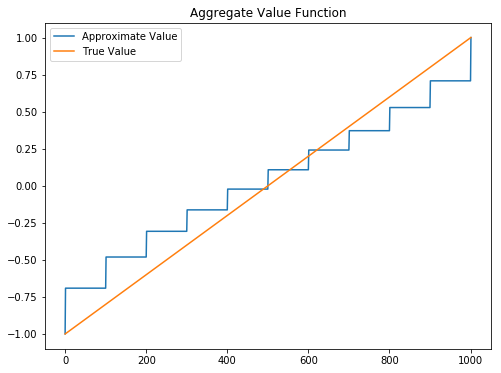

In [10]:
plot_figure(value_function, func_type='Aggregate Value Function')

#### 2) Polynomial Linear Value Function

In [11]:
value_function = LinearValueFunction(order=5, method="polinomial")
env.play(num_episodes=num_episodes, value_function=value_function)

Episode: 30000/ 30000 | Max Average Score: 0.14

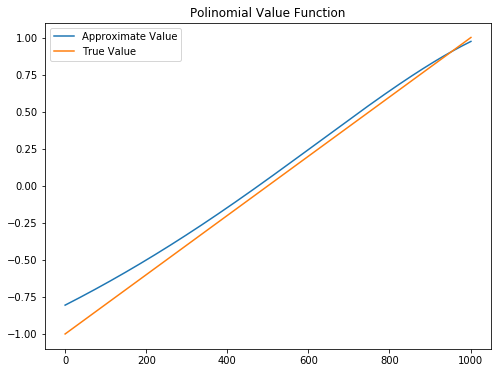

In [12]:
plot_figure(value_function, func_type='Polinomial Value Function')

#### 3) Fourier Linear Value Function

In [13]:
value_function = LinearValueFunction(order=5, method="fourier")
env.play(num_episodes=num_episodes, value_function=value_function)

Episode: 30000/ 30000 | Max Average Score: 0.12

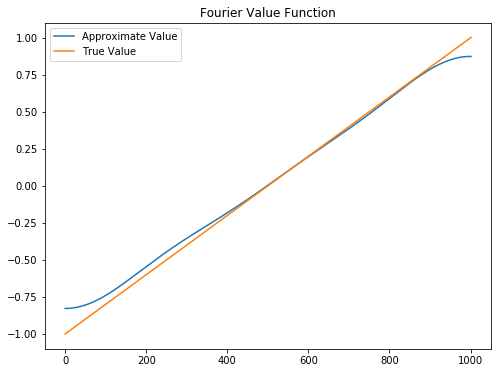

In [14]:
plot_figure(value_function, func_type='Fourier Value Function')

---